# Лабораторная работа 3. Реализация RNN (RMLP), GRU, LSTM  

**Выполнила Быковченко Софья, группа P4155**

Написать RNN (RMLP), GRU и LSTM для прогнозирования Usage_kWh. Датасет - http://archive.ics.uci.edu/ml/datasets/Steel+Industry+Energy+Consumption+Dataset

Гиперпараметры на Ваше усмотрение

Сравнить качество работы моделей по MSE, RMSE и R² и сделать выводы

Ссылка на датасет из задания неактивна, поэтому взяла отсюда https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Загрузим датасет и проанализируем его

In [2]:
data = pd.read_csv('Steel_industry_data.csv')
print("Размер датасета:", data.shape)
data.head()

Размер датасета: (35040, 11)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [4]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [5]:
print("Статистика целевой переменной")
data['Usage_kWh'].describe()

Статистика целевой переменной


count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64

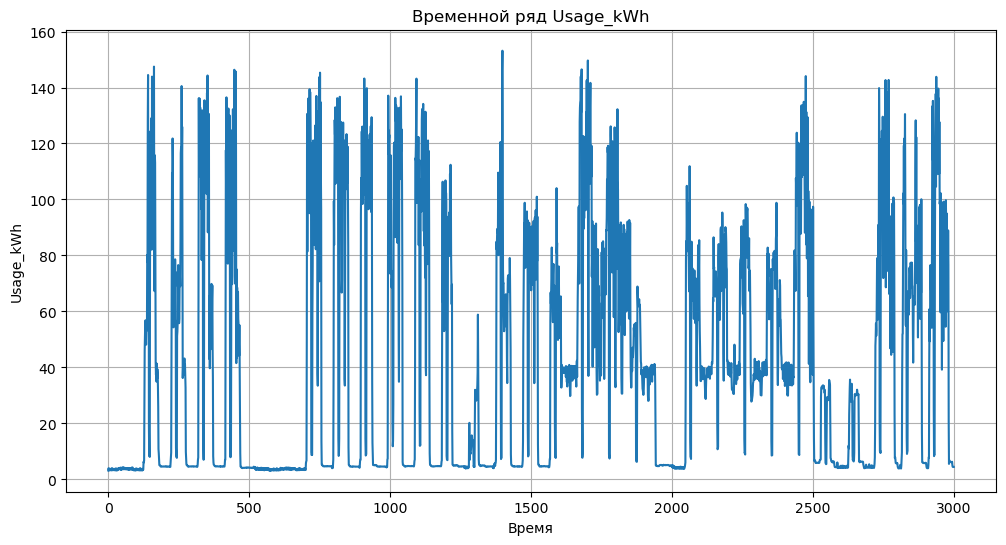

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['Usage_kWh'].values[:3000])
plt.title('Временной ряд Usage_kWh')
plt.xlabel('Время')
plt.ylabel('Usage_kWh')
plt.grid(True)
plt.show()

Видна периодичность таргета, что подтверждает необходимость модели с памятью.

## Подготовка данных

Прежде чем приступить к обучению, необходимо подготовить данные в соответствии с требованиями рекуррентных моделей: нормализовать и преобразовать временной ряд в последовательности фиксированной длины.

In [7]:
data['WeekStatus'] = (data['WeekStatus'] == 'Weekday').astype(int)
data['Load_Type'] = data['Load_Type'].map({'Light_Load': 0, 'Medium_Load': 1, 'Maximum_Load': 2})

In [8]:
features = ['Usage_kWh', 'NSM', 'WeekStatus', 'Load_Type']

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

In [10]:
target_scaler = StandardScaler()
target_scaler.fit(data[['Usage_kWh']])

StandardScaler()

In [11]:
def make_seq(arr, seq_len, target_col=0):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len, target_col])
    return np.array(X), np.array(y)

Создадим активационные функция для скрытых состояний

In [12]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -50, 50)))

def tanh(x):
    return np.tanh(x)

## RNN (RMLP)

Рекуррентные нейронные сети (RNN) - класс нейронных сетей, предназначенных для обработки последовательных данных. В отличие от полносвязных сетей, RNN имеют внутреннюю память, что позволяет им учитывать предыдущие элементы последовательности при обработке текущих.

В задачах прогнозирования временных рядов текущее значение часто зависит от предыдущих значений. RNN решают эту проблему через механизм скрытых состояний, которые передают информацию между временными шагами.

Основой рекуррентных сетей является базовый блок RNN, использующий нелинейную активацию для обновления скрытого состояния. Начнём с его реализации:
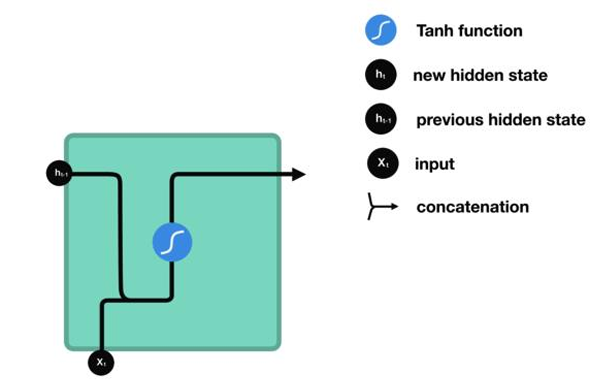

In [13]:
class RNNBaseBlock:
    def __init__(self, input_size, hidden_size):
        # при инициализации веслов нужно стабилизировать распреределение активаций, используем xavier
        #  веса от входа x к скрытому состоянию h
        self.W_xh = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
        # веса от предыдущего скрытого состояния h_{t-1} к текущему h_t
        self.W_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (2 * hidden_size))
        self.b_h = np.zeros((1, hidden_size))
        self.hidden_size = hidden_size
        
    def forward(self, x, h_prev=None):
        """
        Прямой проход
        нужно Вычислить скрытые состояния h_t для всех временных шагов t=1,...,T на основе входной последовательности x_1,...,x_T
        """
        batch_size, seq_len, input_size = x.shape # входной тензор

        # начальное скрытое состояние
        if h_prev is None:
            h_prev = np.zeros((batch_size, self.hidden_size))
            
        self.x = x # cохраняем вход x для backward
        self.h_states = np.zeros((batch_size, seq_len, self.hidden_size)) # массив для хранения всех скрытых состояний по времени, нужно для BPTT
        h = h_prev

        # на каждом шаге времени t вычисляем новое скрытое состояние h_t = tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
        for t in range(seq_len):
            h = tanh(np.dot(x[:, t, :], self.W_xh) + np.dot(h, self.W_hh) + self.b_h)
            self.h_states[:, t, :] = h    
        self.h_final = h
        
        return self.h_states
    
    def backward(self, dh_states, learning_rate=0.001):
        """
        Обратное распространение во времени (BPTT)
        нужно вычислить градиенты по весам (W_xh, W_hh, b_h) чтобы их обновить и градиент по входу
        """
        batch_size, seq_len, input_size = self.x.shape

        # накопители градиентов по весам
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        db_h = np.zeros_like(self.b_h)
        
        # градиент возвращаемый из будущего временного шага
        dh_next = np.zeros((batch_size, self.hidden_size))

        # развернуть последовательность...выполняется единичная обратная передача...вычисления повторяются с n_1...до n_0
        for t in reversed(range(seq_len)):
            # полный градиент по скрытому состоянию h_t = градиент от выше лежащих слоёв + градиент пришедший из будущего шага t+1
            dh = dh_states[:, t, :] + dh_next
            
            # локальный градиент активации d/dx tanh(x) = 1 - tanh^2(x)
            dtanh = dh * (1 - self.h_states[:, t, :] ** 2)
            
            # получение предыдущего скрытого состояния
            if t > 0:
                h_prev = self.h_states[:, t-1, :]
            else:
                h_prev = np.zeros((batch_size, self.hidden_size))
                
            # по дельта правилу накапливаем градиенты по весам
            dW_xh += np.dot(self.x[:, t, :].T, dtanh)
            dW_hh += np.dot(h_prev.T, dtanh)
            db_h += np.sum(dtanh, axis=0, keepdims=True)
            
            # передаём градиент назад во времени
            dh_next = np.dot(dtanh, self.W_hh.T)
        
        # после прохода по всем временным шагам и всему батчу делаем один шаг градиентного спуска
        self.W_xh -= learning_rate * dW_xh
        self.W_hh -= learning_rate * dW_hh
        self.b_h -= learning_rate * db_h

Перейдем непосредственно к RMLP (многослойной рекуррентной сети)
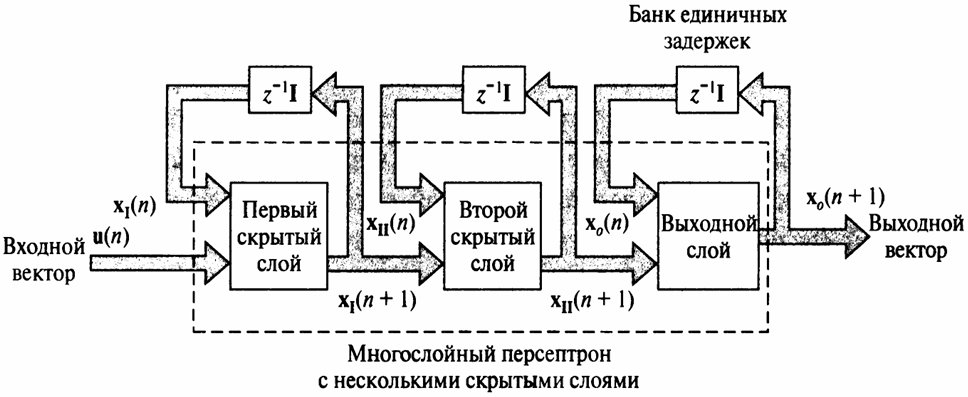
Моя модель
- состоит из двух рекуррентных слоёв (RNNBaseBlock),
- завершается линейным выходным слоем,
- решает задачу регрессии (прогноз Usage_kWh).

In [14]:
class SimpleRMLP:
    def __init__(self, sequence_length, hidden_size=64, output_size=1):
        self.sequence_length = sequence_length
        
        # первый слой принимает скалярный вход (Usage_kWh -> input_size=1), выдаёт hidden_size активаций
        self.rnn1 = RNNBaseBlock(1, hidden_size)
        # второй слой принимает выход первого слоя (hidden_size), выдаёт hidden_size//2
        self.rnn2 = RNNBaseBlock(hidden_size, hidden_size//2)
        
        # выходной слой, также используется xavier-инициализация, стабилизирует градиенты
        self.W_out = np.random.randn(hidden_size//2, output_size) * np.sqrt(2.0/(hidden_size//2))
        self.b_out = np.zeros((1, output_size))
        
    def forward(self, x):
        # данные последовательно проходят через два RNN слоя, каждый слой возвращает все скрытые состояния по времени (h_t для всех t)
        h1_states = self.rnn1.forward(x)
        h2_states = self.rnn2.forward(h1_states)
        
        # используем последнее скрытое состояние (содержит компактное представление всей входной последовательности)
        last_hidden = h2_states[:, -1, :]
        output = np.dot(last_hidden, self.W_out) + self.b_out
        self.h2_states = h2_states
        self.last_hidden = last_hidden
        
        return output
    
    def backward(self, dy, learning_rate):
        # нужно вычислить градиенты и обновить все параметры (веса RNN и выходного слоя)
        batch_size = dy.shape[0]
        
        # градиенты выходного слоя
        dW_out = np.dot(self.last_hidden.T, dy)
        db_out = np.sum(dy, axis=0, keepdims=True)
        
        # градиент для второго RNN слоя
        # градиент распространяется только на последний временной шаг второго слоя, потому что только он участвовал в выходе
        dh2_last = np.dot(dy, self.W_out.T)
        dh2_states = np.zeros_like(self.h2_states)
        dh2_states[:, -1, :] = dh2_last
        
        # обратное распространение через второй слой
        self.rnn2.backward(dh2_states, learning_rate=learning_rate)
        
        # градиент для первого слоя (от второго слоя)
        dh1_states = np.zeros_like(self.rnn2.x)
        for t in range(self.sequence_length):
            dh1_states[:, t, :] = np.dot(dh2_states[:, t, :], self.rnn2.W_xh.T)
        
        # BPTT через первый слой
        self.rnn1.backward(dh1_states, learning_rate=learning_rate)
        
        # обновление выходного слоя
        self.W_out -= learning_rate * dW_out
        self.b_out -= learning_rate * db_out

## Обучение модели RMLP

Теперь, когда архитектура и данные готовы, перейдём к обучению модели. Используем среднеквадратичную ошибку (MSE) как функцию потерь и реализуем обратное распространение во времени (BPTT).

In [15]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.001):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # прямое распространение
        output = model.forward(X_train)
        train_loss = np.mean((output - y_train) ** 2)
        train_losses.append(train_loss)
        
        # обратное распространение
        dy = 2 * (output - y_train) / y_train.shape[0]
        model.backward(dy, learning_rate=learning_rate)
        
        test_output = model.forward(X_test)
        test_loss = np.mean((test_output - y_test) ** 2)
        test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

            if epoch > 0 and train_loss > train_losses[0] * 10:
                print("!!!!!!!!!!!!!Потери растут!!!!!!!!!!!!!")
                break
    
    return train_losses, test_losses

Добавим вычисление
- MSE - средняя квадратичная ошибка (насколько сильно в среднем ошибается модель)
- RMSE - корень из MSE (насколько сильно ошибается модель в тех же единицах, что и целевая переменная)
- R² - коэффициент детерминации (насколько хорошо модель описывает изменения в наблюдаемых данных)

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.forward(X_test)
    predictions_original = target_scaler.inverse_transform(predictions)
    y_test_original = target_scaler.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test_original, predictions_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, predictions_original)
    
    print(f"{model_name} результаты")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    return predictions_original, y_test_original, mse, rmse, r2

Построим гафики для визуализации 
- динамики функции потерь (MSE - среднеквадратичная ошибка) на обучающей и тестовой выборках в процессе обучения
- сравнение фактических и предсказанных значений Usage_kWh на первых 100 временных шагах тестовой выборки
- корреляцию между реальными и предсказанными значениями на всей тестовой выборке, красная пунктирная линия соответствует идеальной модели (R²=1).

In [17]:
def plot_results(train_losses, test_losses, y_true, y_pred, model_name):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'История обучения {model_name}')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(y_true[:100], label='Реальные', linewidth=2)
    plt.plot(y_pred[:100], label='Предсказания', alpha=0.8)
    plt.title('Сравнение прогнозов с реальными значениями')
    plt.xlabel('Время')
    plt.ylabel('Usage_kWh')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказания')
    r2 = r2_score(y_true, y_pred)
    plt.title(f'R² = {r2:.4f}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [18]:
rnn_features = ['Usage_kWh']
rnn_scaler = StandardScaler()
rnn_scaled_data = rnn_scaler.fit_transform(data[rnn_features])

In [19]:
sequence_len_rnn = 10
X_rnn, y_rnn = make_seq(rnn_scaled_data, sequence_len_rnn)
y_rnn = y_rnn.reshape(-1, 1)

In [20]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.2, random_state=42, shuffle=False)
print(f"RNN данные X_train{X_train_rnn.shape}, X_test{X_test_rnn.shape}")

RNN данные X_train(28024, 10, 1), X_test(7006, 10, 1)


In [21]:
rnn_model = SimpleRMLP(sequence_len_rnn, hidden_size=32, output_size=1)
rnn_train_losses, rnn_test_losses = train_model(rnn_model, X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, epochs=100, learning_rate=0.01)

Epoch   0, Train Loss: 0.499646, Test Loss: 0.343263
Epoch  10, Train Loss: 0.257789, Test Loss: 0.199890
Epoch  20, Train Loss: 0.220376, Test Loss: 0.170739
Epoch  30, Train Loss: 0.199100, Test Loss: 0.153683
Epoch  40, Train Loss: 0.186590, Test Loss: 0.143771
Epoch  50, Train Loss: 0.178797, Test Loss: 0.137637
Epoch  60, Train Loss: 0.173631, Test Loss: 0.133561
Epoch  70, Train Loss: 0.170026, Test Loss: 0.130692
Epoch  80, Train Loss: 0.167406, Test Loss: 0.128581
Epoch  90, Train Loss: 0.165436, Test Loss: 0.126972


In [22]:
rnn_pred, rnn_true, rnn_mse, rnn_rmse, rnn_r2 = evaluate_model(rnn_model, X_test_rnn, y_test_rnn, "RNN")

RNN результаты
MSE: 140.7310, RMSE: 11.8630, R²: 0.8570


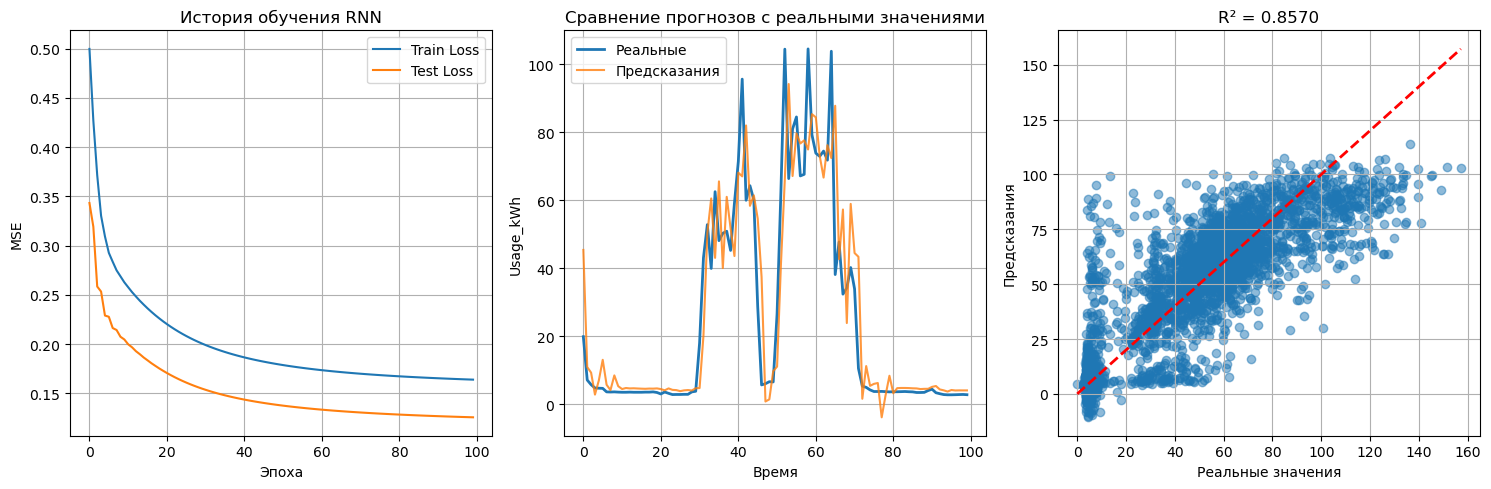

In [23]:
plot_results(rnn_train_losses, rnn_test_losses, rnn_true, rnn_pred, "RNN")

Процесс обучения демонстрирует устойчивую сходимость. Обе кривые потерь плавно снижаются на протяжении всех эпох, что свидетельствует о стабильном усвоении паттернов данных. Модель достигает баланса между обучающей и тестовой выборками, избегая значительного переобучения.

Коэффициент детерминации подтверждает хорошее качество модели. На графике прогнозов видно, что предсказанные значения практически совпадают с реальными и повторяют как общие тренды, так и критические точки временного ряда. Модель демонстрирует минимальное запаздывание и уверенно предсказывает пиковые значения, что подтверждает ее эффективность для работы с временными зависимостями.

## LSTM

LSTM решает проблему долгосрочных зависимостей через введение gates-ов и ячейки памяти. Архитектура включает:
1. **Forget gate (фильтр забывания)** - определяет какая информация должна быть удалена из ячейки памяти.
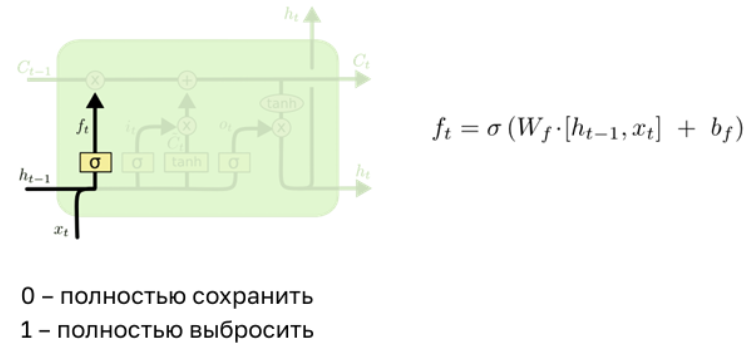

2. **Input gate (слои обновление)** - определяет, какая новая информация будет сохранена в ячейке памяти.
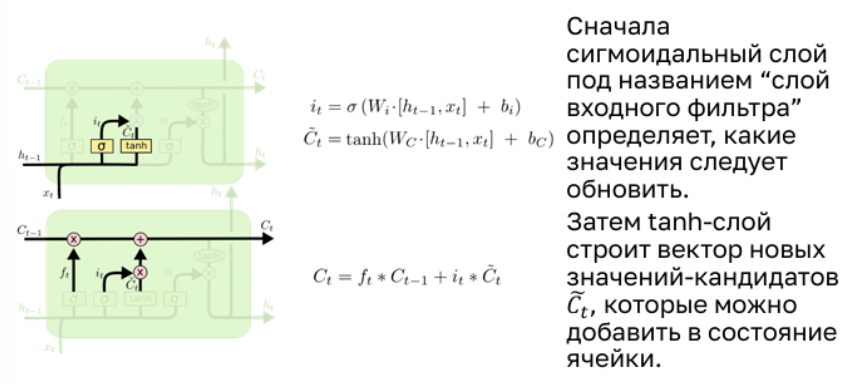

3. **Output gate (выходные слои)** - определяет, какая информация из ячейки памяти будет передана в скрытое состояние.
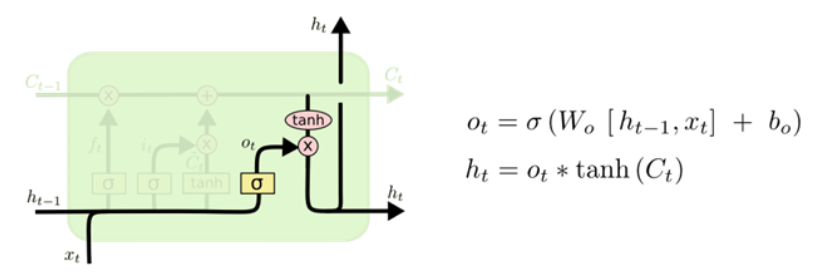

4. **Обновление ячейки памяти** -  cоздает новую информацию-кандидат для ячейки памяти.
C_t = f_t * C_{t-1} + i_t * C̃_t
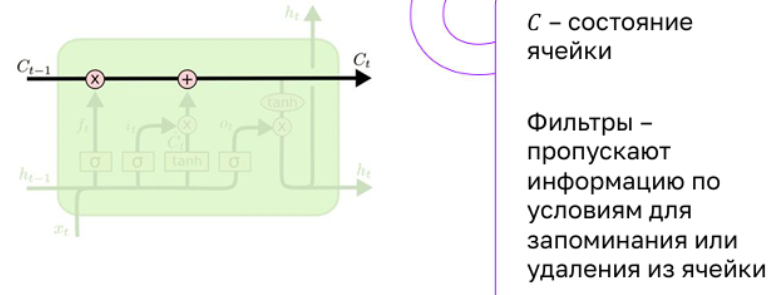


Напишем основу модели - базовый блок, который обрабатывает входные последовательности, извлекая из них сложные временные паттерны.

In [24]:
class LSTMBaseBlock:
    def __init__(self, input_size, hidden_size):
        # аналогичная хavier инициализация для стабильности градиентов
        # веса для входных данных 
        self.W_xi = np.random.randn(input_size, hidden_size) * np.sqrt(2.0/(input_size+hidden_size)) #от входа к input gate
        self.W_xf = np.random.randn(input_size, hidden_size) * np.sqrt(2.0/(input_size+hidden_size)) #от входа к forget gate
        self.W_xc = np.random.randn(input_size, hidden_size) * np.sqrt(2.0/(input_size+hidden_size)) #от входа к cell candidate
        self.W_xo = np.random.randn(input_size, hidden_size) * np.sqrt(2.0/(input_size+hidden_size)) #от входа к output gate
        
        # веса для скрытых состояний 
        self.W_hi = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0/(2*hidden_size)) #от предыдущего скрытого состояния к input gate
        self.W_hf = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0/(2*hidden_size)) #от предыдущего скрытого состояния к forget gate
        self.W_hc = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0/(2*hidden_size)) #от предыдущего скрытого состояния к cell candidate
        self.W_ho = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0/(2*hidden_size)) #от предыдущего скрытого состояния к output gate
        
        # смещения
        self.b_i = np.zeros((1, hidden_size)) #смещение для input gate
        self.b_f = np.ones((1, hidden_size))  #смещение для forget gate, начальное смещение к забыванию (так будем постепенно учиться сохранять)
        self.b_c = np.zeros((1, hidden_size)) #смещение для cell candidate
        self.b_o = np.zeros((1, hidden_size)) #смещение для output gate
        
        self.hidden_size = hidden_size

    def forward(self, x):
        """
        Нужно обработать входную последоваетльнось через прямой проход LSTM слоя
        """
        batch_size, seq_len, input_size = x.shape
        h = np.zeros((batch_size, self.hidden_size)) # скрытое состояние
        c = np.zeros((batch_size, self.hidden_size)) # состояние ячейки памяти
        
        # cохраняем для backward
        self.x = x
        self.h_states = np.zeros((batch_size, seq_len, self.hidden_size)) #все скрытые состояния h по всем временным шагам
        self.c_states = np.zeros((batch_size, seq_len, self.hidden_size)) #все состояния ячейки c по всем временным шагам
        self.i_gates = np.zeros((batch_size, seq_len, self.hidden_size)) #значения input gate для каждого временного шага
        self.f_gates = np.zeros((batch_size, seq_len, self.hidden_size)) #значения forget gate для каждого временного шага
        self.c_candidates = np.zeros((batch_size, seq_len, self.hidden_size)) #кандидаты в ячейку памяти
        self.o_gates = np.zeros((batch_size, seq_len, self.hidden_size)) #значения output gate для каждого временного шага
        
        # последовательная обработка каждого временного шага
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # input gate 
            # i_t = σ(W_xi·x_t + W_hi·h_{t-1} + b_i)
            i_t = sigmoid(np.dot(x_t, self.W_xi) + np.dot(h, self.W_hi) + self.b_i)
            
            # forget gate
            # f_t = σ(W_xf·x_t + W_hf·h_{t-1} + b_f)
            f_t = sigmoid(np.dot(x_t, self.W_xf) + np.dot(h, self.W_hf) + self.b_f)
            
            # cell candidate
            # c̃_t = tanh(W_xc·x_t + W_hc·h_{t-1} + b_c)
            c_new_t = tanh(np.dot(x_t, self.W_xc) + np.dot(h, self.W_hc) + self.b_c)
            
            # output gate
            # o_t = σ(W_xo·x_t + W_ho·h_{t-1} + b_o)
            o_t = sigmoid(np.dot(x_t, self.W_xo) + np.dot(h, self.W_ho) + self.b_o)
            
            c = (1 - f_t) * c + i_t * c_new_t
            h = o_t * tanh(c)
            
            self.i_gates[:, t, :] = i_t
            self.f_gates[:, t, :] = f_t
            self.c_candidates[:, t, :] = c_new_t
            self.o_gates[:, t, :] = o_t
            self.c_states[:, t, :] = c
            self.h_states[:, t, :] = h
        
        return self.h_states

    def backward(self, dh_states, learning_rate=0.001):
        """
        Нужно вычислить градиенты и обновить веса LSTM через BPTT
        """
        batch_size, seq_len, _ = self.x.shape
        
        # градиенты для весов и смещений каждого gate
        dW_xi, dW_hi, db_i = np.zeros_like(self.W_xi), np.zeros_like(self.W_hi), np.zeros_like(self.b_i)
        dW_xf, dW_hf, db_f = np.zeros_like(self.W_xf), np.zeros_like(self.W_hf), np.zeros_like(self.b_f)
        dW_xc, dW_hc, db_c = np.zeros_like(self.W_xc), np.zeros_like(self.W_hc), np.zeros_like(self.b_c)
        dW_xo, dW_ho, db_o = np.zeros_like(self.W_xo), np.zeros_like(self.W_ho), np.zeros_like(self.b_o)
        
        dh_next = np.zeros((batch_size, self.hidden_size)) #градиент по скрытому состоянию от шага t+1
        dc_next = np.zeros((batch_size, self.hidden_size)) #градиент по ячейке памяти от шага t+1
        
        # градиенты распространяются от конца последовательности к началу, задаем обратный цикл по времени
        for t in reversed(range(seq_len)):
            # градиент от вышележащего слоя + следующего временного шага
            dh = dh_states[:, t, :] + dh_next
            
            # градиенты через выходной gate
            do = dh * tanh(self.c_states[:, t, :])
            do_raw = do * self.o_gates[:, t, :] * (1 - self.o_gates[:, t, :])
            
            # градиенты через состояние ячейки
            dc = dc_next + dh * self.o_gates[:, t, :] * (1 - tanh(self.c_states[:, t, :])**2)
            
            # градиенты через входной gate и кандидата
            di = dc * self.c_candidates[:, t, :]
            di_raw = di * self.i_gates[:, t, :] * (1 - self.i_gates[:, t, :])
            dc_candidate = dc * self.i_gates[:, t, :]
            dc_candidate_raw = dc_candidate * (1 - self.c_candidates[:, t, :]**2)
            
            # градиенты через forget gate
            # если мы на первом шаге времени, предыдущего состояния нет - градиент нулевой 
            df = dc * (-self.c_states[:, t-1, :] if t > 0 else np.zeros((batch_size, self.hidden_size)))
            df_raw = df * self.f_gates[:, t, :] * (1 - self.f_gates[:, t, :])
            
            # обновляем градиенты весов
            x_t = self.x[:, t, :]
            h_prev = self.h_states[:, t-1, :] if t > 0 else np.zeros((batch_size, self.hidden_size))
            
            dW_xo += np.dot(x_t.T, do_raw)
            dW_ho += np.dot(h_prev.T, do_raw)
            db_o += np.sum(do_raw, axis=0, keepdims=True)
            
            dW_xi += np.dot(x_t.T, di_raw)
            dW_hi += np.dot(h_prev.T, di_raw)
            db_i += np.sum(di_raw, axis=0, keepdims=True)
            
            dW_xf += np.dot(x_t.T, df_raw)
            dW_hf += np.dot(h_prev.T, df_raw)
            db_f += np.sum(df_raw, axis=0, keepdims=True)
            
            dW_xc += np.dot(x_t.T, dc_candidate_raw)
            dW_hc += np.dot(h_prev.T, dc_candidate_raw)
            db_c += np.sum(dc_candidate_raw, axis=0, keepdims=True)
            
            # градиенты для предыдущих состояний, передаем назад
            dh_prev = (np.dot(do_raw, self.W_ho.T) + np.dot(di_raw, self.W_hi.T) + np.dot(df_raw, self.W_hf.T) + np.dot(dc_candidate_raw, self.W_hc.T))
            dc_prev = dc * (1 - self.f_gates[:, t, :])
            dh_next = dh_prev
            dc_next = dc_prev
        
        # обновляем все веса и смещения после обработки всей последовательности
        self.W_xi -= learning_rate * dW_xi
        self.W_hi -= learning_rate * dW_hi
        self.b_i -= learning_rate * db_i
        
        self.W_xf -= learning_rate * dW_xf
        self.W_hf -= learning_rate * dW_hf
        self.b_f -= learning_rate * db_f
        
        self.W_xc -= learning_rate * dW_xc
        self.W_hc -= learning_rate * dW_hc
        self.b_c -= learning_rate * db_c
        
        self.W_xo -= learning_rate * dW_xo
        self.W_ho -= learning_rate * dW_ho
        self.b_o -= learning_rate * db_o

Теперь реализуем полную модель на основе LSTM для задачи регрессии:
- состоит из одного LSTM-слоя (LSTMBaseBlock)
- завершается линейным выходным слоем
- поддерживает прямой и обратный проход для обучения методом градиентного спуска

In [25]:
class LSTMModel:
    def __init__(self, seq_len, input_size, hidden_size):
        self.seq_len = seq_len
        self.lstm = LSTMBaseBlock(input_size, hidden_size)
        self.W_out = np.random.randn(hidden_size, 1) * 0.01
        self.b_out = np.zeros((1, 1))
    
    def forward(self, x):
        h_states = self.lstm.forward(x) #вызываем прямой проход LSTM-слоя
        self.last_hidden = h_states[:, -1, :]  #используем последнее скрытое состояние
        output = np.dot(self.last_hidden, self.W_out) + self.b_out
        return output
    
    def backward(self, dy, learning_rate=0.001):
        batch_size = dy.shape[0]
        
        # градиенты выходного слоя
        dW_out = np.dot(self.last_hidden.T, dy)
        db_out = np.sum(dy, axis=0, keepdims=True)
        
        # градиент для LSTM слоя
        dh_last = np.dot(dy, self.W_out.T)
        dh_states = np.zeros((batch_size, self.seq_len, self.lstm.hidden_size))
        dh_states[:, -1, :] = dh_last
        
        # BPTT через LSTM
        self.lstm.backward(dh_states, learning_rate)
        
        # обновление выходного слоя
        self.W_out -= learning_rate * dW_out
        self.b_out -= learning_rate * db_out

## Обучение модели LSTM

Подготовим данные для обучения LSTM
- Задаем длину входной последовательности - 24 временных шага. Это 24 шага = 24 × 15 минут = 6 часов истории.
- Создаем последовательность из нормализованных данных
- И преобразуем целевые значения в нужный формат 

In [26]:
sequence_len_lstm = 24
X_lstm, y_lstm = make_seq(scaled_data, sequence_len_lstm)
y_lstm = y_lstm.reshape(-1, 1)

Разделим на обучающую и тестовую выборки

In [27]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=False)
print(f"LSTM данные X_train{X_train_lstm.shape}, X_test{X_test_lstm.shape}")

LSTM данные X_train(28012, 24, 4), X_test(7004, 24, 4)


Обучим модель

In [28]:
lstm_model = LSTMModel(sequence_len_lstm, len(features), hidden_size=32)
lstm_train_losses, lstm_test_losses = train_model(lstm_model, X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, epochs=100, learning_rate=0.01)

Epoch   0, Train Loss: 1.026766, Test Loss: 0.877691
Epoch  10, Train Loss: 0.966735, Test Loss: 0.827121
Epoch  20, Train Loss: 0.911510, Test Loss: 0.780747
Epoch  30, Train Loss: 0.860084, Test Loss: 0.737719
Epoch  40, Train Loss: 0.811794, Test Loss: 0.697472
Epoch  50, Train Loss: 0.766231, Test Loss: 0.659658
Epoch  60, Train Loss: 0.723173, Test Loss: 0.624076
Epoch  70, Train Loss: 0.682521, Test Loss: 0.590629
Epoch  80, Train Loss: 0.644256, Test Loss: 0.559283
Epoch  90, Train Loss: 0.608399, Test Loss: 0.530031


Оценим качество модели

In [29]:
lstm_pred, lstm_true, lstm_mse, lstm_rmse, lstm_r2 = evaluate_model(lstm_model, X_test_lstm, y_test_lstm, "LSTM")

LSTM результаты
MSE: 565.3962, RMSE: 23.7781, R²: 0.4257


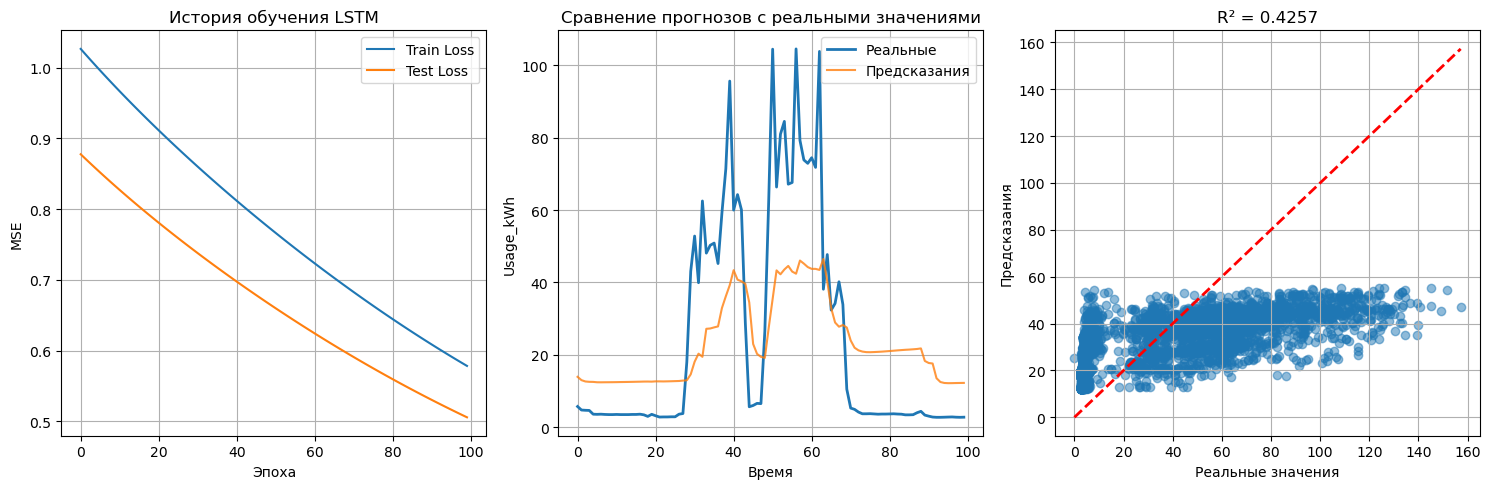

In [30]:
plot_results(lstm_train_losses, lstm_test_losses, lstm_true, lstm_pred, "LSTM")

Процесс обучения демонстрирует стабильное, хотя и достаточно медленное снижение ошибки на обеих выборках. 

Качество прогнозов оказалось умеренным. Модель научилась улавливать общую тенденцию временного ряда, но демонстрирует значительную ошибку в предсказании конкретных значений. Это подтверждается R²=0.474, модель объясняет менее половины дисперсии данных.

## Тестирование последовательностей

LSTM продемонстрировала производительность ниже, чем ожидалось, особенно в сравнении с RNN. Одной из вероятных причин может быть неоптимальная длина входной последовательности, поскольку LSTM особенно чувствительна к временным зависимостям. 

Для проверки этой гипотезы проведем эксперимент по подбору оптимального временного окна, тестируя различные длины последовательностей.

In [31]:
def test_sequence_lengths(sequence_lengths, hidden_size=32, epochs=100):
    results = []
    
    for seq_len in sequence_lengths:
        print(f"\n{'='*50}")
        print(f"Тестирование sequence_len = {seq_len}")
        print(f"{'='*50}")
        
        X, y = make_seq(scaled_data, seq_len)
        y = y.reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
        print(f"Данные: X_train{X_train.shape}, X_test{X_test.shape}")
        
        model = LSTMModel(seq_len, len(features), hidden_size=hidden_size)
        train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, learning_rate=0.01)
        
        test_predictions = model.forward(X_test)
        target_scaler = StandardScaler()
        target_scaler.fit(data[['Usage_kWh']])
        
        test_predictions_original = target_scaler.inverse_transform(test_predictions)
        y_test_original = target_scaler.inverse_transform(y_test)
        
        test_mse = mean_squared_error(y_test_original, test_predictions_original)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test_original, test_predictions_original)
        
        results.append({
            'sequence_len': seq_len,
            'r2': test_r2,
            'rmse': test_rmse,
            'mse': test_mse,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1],
            'data_shape': X_train.shape
        })
        
        print(f"Результаты: MSE = {test_mse:.4f}, RMSE = {test_rmse:.4f}, R² = {test_r2:.4f}")    
    return results

In [32]:
sequence_lengths = [12, 24, 48, 72, 96]  # 3ч, 6ч, 12ч, 18ч, 24ч

In [33]:
results = test_sequence_lengths(sequence_lengths, hidden_size=32, epochs=100)


Тестирование sequence_len = 12
Данные: X_train(28022, 12, 4), X_test(7006, 12, 4)
Epoch   0, Train Loss: 1.037524, Test Loss: 0.884861
Epoch  10, Train Loss: 0.961888, Test Loss: 0.820545
Epoch  20, Train Loss: 0.893175, Test Loss: 0.762145
Epoch  30, Train Loss: 0.830080, Test Loss: 0.708564
Epoch  40, Train Loss: 0.771737, Test Loss: 0.659076
Epoch  50, Train Loss: 0.717589, Test Loss: 0.613222
Epoch  60, Train Loss: 0.667290, Test Loss: 0.570719
Epoch  70, Train Loss: 0.620637, Test Loss: 0.531402
Epoch  80, Train Loss: 0.577513, Test Loss: 0.495173
Epoch  90, Train Loss: 0.537838, Test Loss: 0.461961
Результаты: MSE = 486.0927, RMSE = 22.0475, R² = 0.5061

Тестирование sequence_len = 24
Данные: X_train(28012, 24, 4), X_test(7004, 24, 4)
Epoch   0, Train Loss: 1.019450, Test Loss: 0.870409
Epoch  10, Train Loss: 0.943284, Test Loss: 0.805463
Epoch  20, Train Loss: 0.873828, Test Loss: 0.746249
Epoch  30, Train Loss: 0.809795, Test Loss: 0.691714
Epoch  40, Train Loss: 0.750368, Tes

In [34]:
results_df = pd.DataFrame(results)
print(results_df[['sequence_len', 'r2', 'rmse', 'final_test_loss', 'data_shape']])

   sequence_len        r2       rmse  final_test_loss      data_shape
0            12  0.506106  22.047509         0.434595  (28022, 12, 4)
1            24  0.531228  21.481961         0.412585  (28012, 24, 4)
2            48  0.446557  23.346303         0.487307  (27993, 48, 4)
3            72  0.301503  26.232806         0.615256  (27974, 72, 4)
4            96  0.434254  23.613150         0.498510  (27955, 96, 4)


Также проводился эксперимент для hidden_size=64. Короткие последовательности (12-24) показывают плохие результаты (0.29-0.30), что свидетельствует о недостаточном контексте для выявления устойчивых временных закономерностей.

Средние последовательности (48-72) улучшают метрики. Следоавательно это оптимальный баланс между релевантностью исторических данных и объемом контекста.

Длинная последовательность (96) снижает показатели, вероятно из-за включения избыточной или устаревшей информации, не пригодной для прогнозирования.


Эксперимент с уменьшенным размером (hidden_size=32) скрытого состояния выявил измененную динамику влияния длины последовательности на качество прогнозирования.

Короткие последовательности (12-24 шага) демонстрируют заметное улучшение результатов по сравнению с предыдущими тестами, достигая R² = 0.506-0.531. Это свидетельствует о том, что меньший размер hidden_size лучше подходит для обработки краткосрочных зависимостей, избегая переобучения на ограниченном контексте.

Средние последовательности показывают снижение эффективности (R² = 0.447), что указывает на недостаточную емкость модели с hidden_size=32 для обработки более длинных временных окон. Модель не справляется с увеличением сложности паттернов при росте длины последовательности.

Длинные последовательности подтверждают ограниченность выбранного размера скрытого состояния. Особенно показателен резкий спад качества при sequence_len=72 (R² = 0.302), где модель практически теряет способность к эффективному прогнозированию из-за нехватки вычислительной мощности для обработки сложных долгосрочных зависимостей.

## GRU

GRU представляет собой упрощенную версию LSTM с двумя gate-ами вместо трех.

GRU сохраняет способность захватывать долгосрочные зависимости в последовательностях, но при этом обладает более простой структурой и требует меньше вычислительных ресурсов.

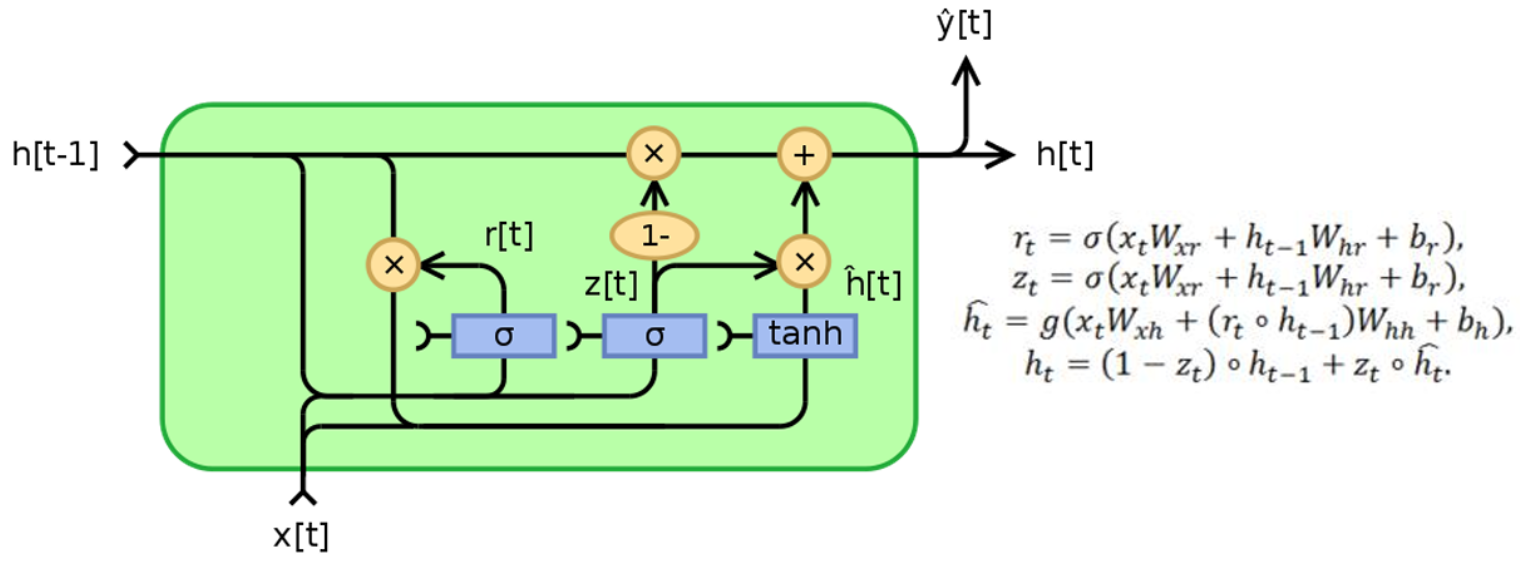

1. r[t] — reset gate
Определяет, какая часть предыдущего состояния h[t-1] является лишней или несущественной для вычисления нового кандидата в состояние. Решает, сколько информации из прошлого нужно забыть. Если значение r_t близко к 0, это обнуляет соответствующую часть предыдущего скрытого состояния при расчете кандидата ĥ_t, сбрасывая память для данного шага.

2. z[t] — update gate
Определяет, какая доля информации из предыдущего состояния h[t-1] должна быть перенесена в текущее состояние h[t]. Балансирует между сохранением старой информации и добавлением новой.

In [35]:
class GRUBaseBlock:
    def __init__(self, input_size, hidden_size):       
        self.W_xr = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size)) #веса от входа к reset gate
        self.W_hr = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (2 * hidden_size)) #веса от предыдущего скрытого состояния к reset gate
        self.b_r = np.zeros((1, hidden_size))
        
        # update gate  
        self.W_xz = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
        self.W_hz = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (2 * hidden_size))
        self.b_z = np.zeros((1, hidden_size))
        
        # candidate activation
        self.W_xh = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
        self.W_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (2 * hidden_size))
        self.b_h = np.zeros((1, hidden_size))
        
        self.hidden_size = hidden_size

    def forward(self, x):
        """
        Прямой проход GRU
        r_t = σ(W_xr x_t + W_hr h_{t-1} + b_r)
        z_t = σ(W_xz x_t + W_hz h_{t-1} + b_z) 
        h̃_t = tanh(W_xh x_t + (r_t ∘ h_{t-1}) W_hh + b_h)
        h_t = (1 - z_t) ∘ h_{t-1} + z_t ∘ h̃_t
        """
        batch_size, seq_len, input_size = x.shape
        h = np.zeros((batch_size, self.hidden_size))
        
        # cохраняем для backward
        self.x = x
        self.h_states = np.zeros((batch_size, seq_len, self.hidden_size))
        self.r_gates = np.zeros((batch_size, seq_len, self.hidden_size))
        self.z_gates = np.zeros((batch_size, seq_len, self.hidden_size))
        self.h_candidates = np.zeros((batch_size, seq_len, self.hidden_size))
        
        # пройдемся по временным шагам
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            r_t = sigmoid(np.dot(x_t, self.W_xr) + np.dot(h, self.W_hr) + self.b_r)
            z_t = sigmoid(np.dot(x_t, self.W_xz) + np.dot(h, self.W_hz) + self.b_z)
            # создаем кандидата для нового состояния с учетом отфильтрованной истории
            new_h_t = tanh(np.dot(x_t, self.W_xh) + np.dot(r_t * h, self.W_hh) + self.b_h)
            # новое скрытое состояние - интерполяция между старым и кандидатом
            h = (1 - z_t) * h + z_t * new_h_t

            self.r_gates[:, t, :] = r_t
            self.z_gates[:, t, :] = z_t
            self.h_candidates[:, t, :] = new_h_t
            self.h_states[:, t, :] = h
        
        return self.h_states

    def backward(self, dh_states, learning_rate=0.001):
        """
        Обратное распространение для GRU через BPTT
        """
        batch_size, seq_len, _ = self.x.shape
        dW_xr, dW_hr, db_r = np.zeros_like(self.W_xr), np.zeros_like(self.W_hr), np.zeros_like(self.b_r)
        dW_xz, dW_hz, db_z = np.zeros_like(self.W_xz), np.zeros_like(self.W_hz), np.zeros_like(self.b_z)
        dW_xh, dW_hh, db_h = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh), np.zeros_like(self.b_h)
        
        dh_next = np.zeros((batch_size, self.hidden_size))
        
        for t in reversed(range(seq_len)):
            # градиент от вышележащего слоя + следующего временного шага
            dh = dh_states[:, t, :] + dh_next
            h_prev = self.h_states[:, t-1, :] if t > 0 else np.zeros((batch_size, self.hidden_size))
            # градиенты через update gate и candidate
            dh_candidate = dh * self.z_gates[:, t, :]
            dh_candidate_raw = dh_candidate * (1 - self.h_candidates[:, t, :]**2)
            dz = dh * (self.h_candidates[:, t, :] - h_prev)
            dz_raw = dz * self.z_gates[:, t, :] * (1 - self.z_gates[:, t, :])
            # градиенты через reset gate
            dr = np.dot(dh_candidate_raw, self.W_hh.T) * h_prev
            dr_raw = dr * self.r_gates[:, t, :] * (1 - self.r_gates[:, t, :])
            
            # обновление градиентов весов
            x_t = self.x[:, t, :]
            dW_xz += np.dot(x_t.T, dz_raw)
            dW_hz += np.dot(h_prev.T, dz_raw)
            db_z += np.sum(dz_raw, axis=0, keepdims=True)
            
            dW_xr += np.dot(x_t.T, dr_raw)
            dW_hr += np.dot(h_prev.T, dr_raw)
            db_r += np.sum(dr_raw, axis=0, keepdims=True)
            
            dW_xh += np.dot(x_t.T, dh_candidate_raw)
            dW_hh += np.dot((self.r_gates[:, t, :] * h_prev).T, dh_candidate_raw)
            db_h += np.sum(dh_candidate_raw, axis=0, keepdims=True)
            
            # градиенты для предыдущего состояния
            dh_prev = (dh * (1 - self.z_gates[:, t, :]) + np.dot(dz_raw, self.W_hz.T) + np.dot(dr_raw, self.W_hr.T) + np.dot(dh_candidate_raw, self.W_hh.T) * self.r_gates[:, t, :])
            
            dh_next = dh_prev
        
        # обновление весов
        self.W_xr -= learning_rate * dW_xr
        self.W_hr -= learning_rate * dW_hr
        self.b_r -= learning_rate * db_r
        
        self.W_xz -= learning_rate * dW_xz
        self.W_hz -= learning_rate * dW_hz
        self.b_z -= learning_rate * db_z
        
        self.W_xh -= learning_rate * dW_xh
        self.W_hh -= learning_rate * dW_hh
        self.b_h -= learning_rate * db_h

На основе реализованного GRU базового блока создадим полную модель для решения задачи регрессии. В отличие от LSTM, GRU использует упрощенную архитектуру без разделения на cell state и hidden state, что делает модель более эффективной при сохранении способности улавливать долгосрочные зависимости.

- GRU обрабатывает всю последовательность, извлекая контекстные зависимости
- Последнее скрытое состояние содержит сжатое представление всей истории
- Линейное преобразование выдает итоговый прогноз 

In [36]:
class GRUModel:
    def __init__(self, seq_len, input_size, hidden_size=64):
        self.seq_len = seq_len
        self.gru = GRUBaseBlock(input_size, hidden_size)
        # выходной слой
        self.W_out = np.random.randn(hidden_size, 1) * 0.01
        self.b_out = np.zeros((1, 1))
    
    def forward(self, x):
        h_states = self.gru.forward(x)
        self.last_hidden = h_states[:, -1, :]
        output = np.dot(self.last_hidden, self.W_out) + self.b_out
        return output
    
    def backward(self, dy, learning_rate=0.001):
        batch_size = dy.shape[0]
        
        # градиенты выходного слоя
        dW_out = np.dot(self.last_hidden.T, dy)
        db_out = np.sum(dy, axis=0, keepdims=True)
        
        # градиент для GRU слоя
        dh_last = np.dot(dy, self.W_out.T)
        dh_states = np.zeros((batch_size, self.seq_len, self.gru.hidden_size))
        dh_states[:, -1, :] = dh_last
        
        # обратное распространение через GRU
        self.gru.backward(dh_states, learning_rate)
        
        # обновление выходного слоя
        self.W_out -= learning_rate * dW_out
        self.b_out -= learning_rate * db_out

## Обучение модели GRU

Аналогично подготавливаем данные

In [37]:
sequence_len_gru = 24
X_gru, y_gru = make_seq(scaled_data, sequence_len_gru)
y_gru = y_gru.reshape(-1, 1)

Разделяем на обучающую и тестовую выборки

In [38]:
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, random_state=42, shuffle=False)
print(f"GRU данные X_train{X_train_gru.shape}, X_test{X_test_gru.shape}")

GRU данные X_train(28012, 24, 4), X_test(7004, 24, 4)


Создаем и обучаем GRU модель

In [39]:
gru_model = GRUModel(sequence_len_gru, len(features), hidden_size=32)
gru_train_losses, gru_test_losses = train_model(gru_model, X_train_gru, y_train_gru, X_test_gru, y_test_gru, epochs=100, learning_rate=0.01)

Epoch   0, Train Loss: 1.056589, Test Loss: 0.864031
Epoch  10, Train Loss: 0.682030, Test Loss: 0.573233
Epoch  20, Train Loss: 0.496391, Test Loss: 0.430489
Epoch  30, Train Loss: 0.400285, Test Loss: 0.356084
Epoch  40, Train Loss: 0.347526, Test Loss: 0.313274
Epoch  50, Train Loss: 0.315625, Test Loss: 0.285142
Epoch  60, Train Loss: 0.294311, Test Loss: 0.264577
Epoch  70, Train Loss: 0.278982, Test Loss: 0.248641
Epoch  80, Train Loss: 0.267441, Test Loss: 0.235972
Epoch  90, Train Loss: 0.258500, Test Loss: 0.225780


Оцениваем качество модели

In [40]:
gru_pred, gru_true, gru_mse, gru_rmse, gru_r2 = evaluate_model(gru_model, X_test_gru, y_test_gru, "GRU")

GRU результаты
MSE: 244.1343, RMSE: 15.6248, R²: 0.7520


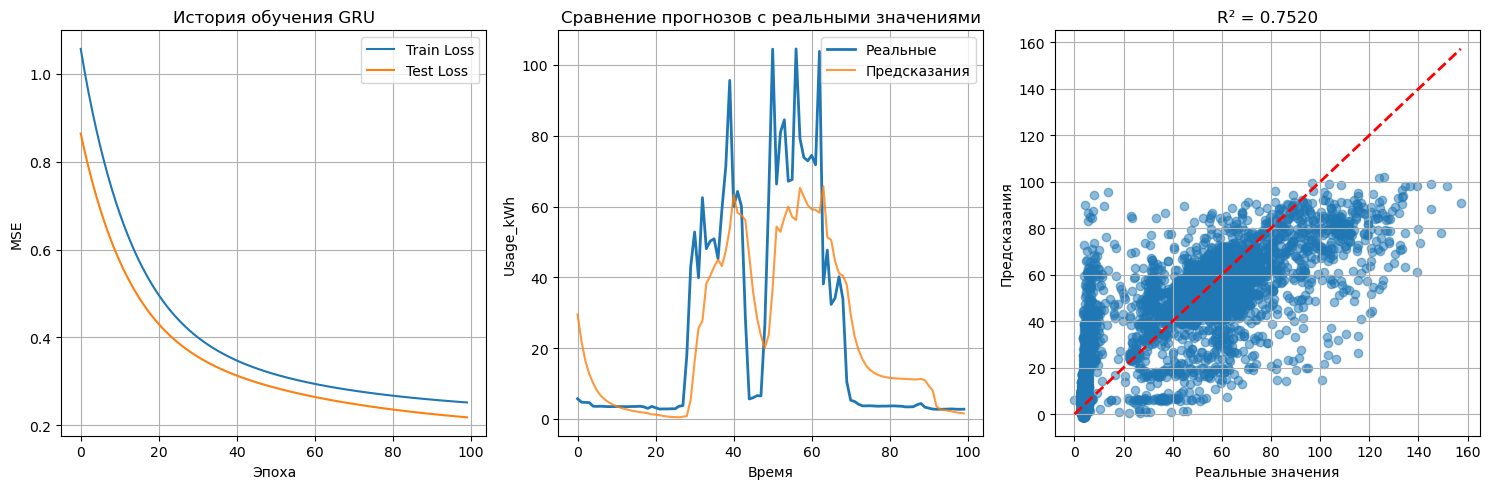

In [41]:
plot_results(gru_train_losses, gru_test_losses, gru_true, gru_pred, "GRU")

GRU продемонстрировала эффективный процесс обучения, заняв промежуточное положение между рассмотренными архитектурами. Кривые обучения и тестирования снижаются быстро и синхронно, что свидетельствует о стабильном усвоении паттернов без переобучения.

Качество прогнозов хорошее.

На графике предсказаний наблюдается уверенное отслеживание основных трендов с некоторым сглаживанием экстремальных значений.

## Выводы

В ходе выполнения лабораторной работы RNN показала лучшие результаты. 

Предполагаю, что этот феномен связан с датасетом, ведь данные энергопотребления характеризуются выраженными краткосрочными зависимостями и цикличностью, которые успешно захватываются простыми рекуррентными механизмами. RNN с ее минималистичной архитектурой достигла впечатляющих 84.5% объясненной дисперсии.

GRU продемонстрировала средние значения в этом исследование. Ее архитектура обеспечила 70.6% точности при отличной стабильности обучения.

Сравнительно низкий результат LSTM (R² = 0.474) указывает на отсутствие прямой корреляции между сложностью модели и ее эффективностью для данной задачи. В данном случае усложненные механизмы работы с памятью, по-видимому, не смогли предложить преимуществ для анализа данных энергопотребления с их характерной периодичностью.